<a href="https://colab.research.google.com/github/2303A51529/NLP-LAB/blob/main/NLP_F_14_11_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing scikit-learn ...
Installing gensim ...
Device: cpu
File /content/train.csv not found — creating a small synthetic demo dataset.
Synthetic dataset created: 800 rows.
Using sample size: 800

=== Computing Word2Vec embeddings ===
Word2Vec matrix shape: (800, 100)

=== Computing ELMo embeddings (this may be slow on first run) ===
ELMo matrix shape: (800, 1024)

=== Computing BERT embeddings ===


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BERT matrix shape: (800, 768)

-- Reducing & visualizing Word2Vec embeddings (shape (800, 100)) --
Running t-SNE... (this may take a while)


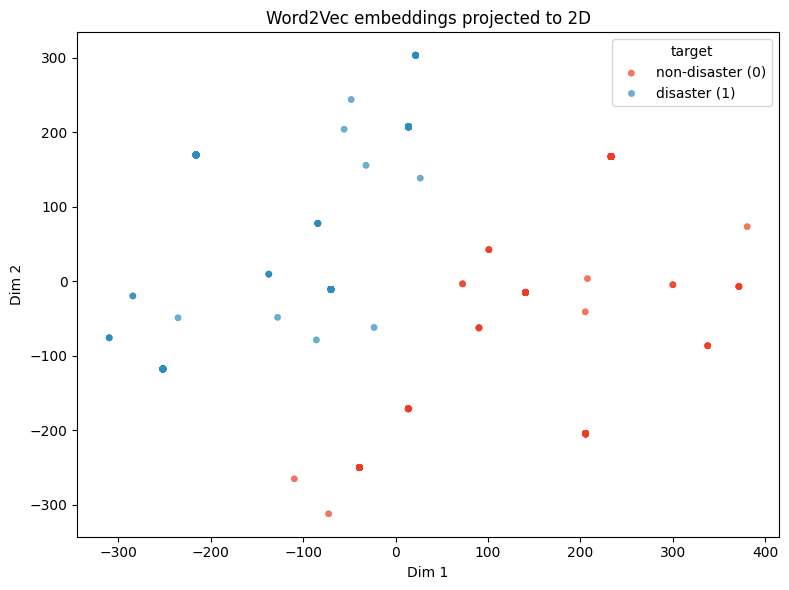

Word2Vec silhouette score (2D projection): 0.4150

-- Reducing & visualizing ELMo embeddings (shape (800, 1024)) --
Running t-SNE... (this may take a while)


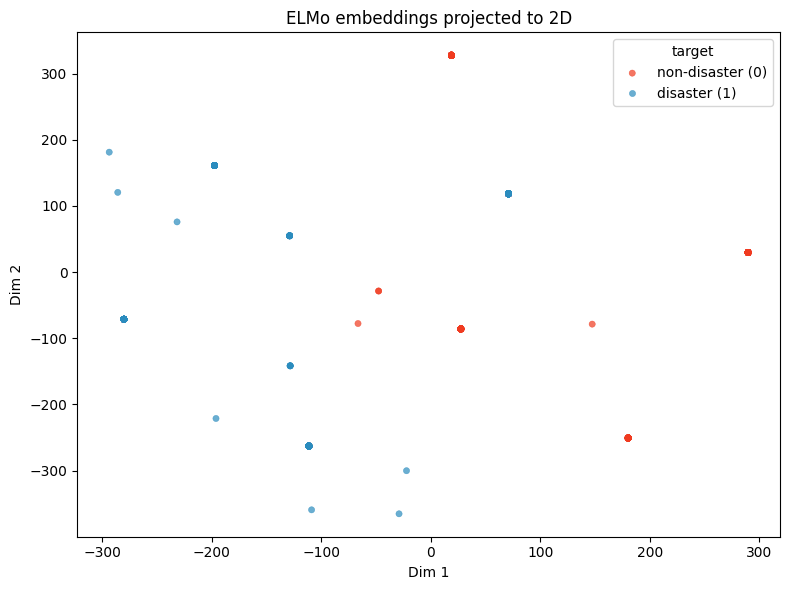

ELMo silhouette score (2D projection): 0.2781

-- Reducing & visualizing BERT embeddings (shape (800, 768)) --
Running t-SNE... (this may take a while)


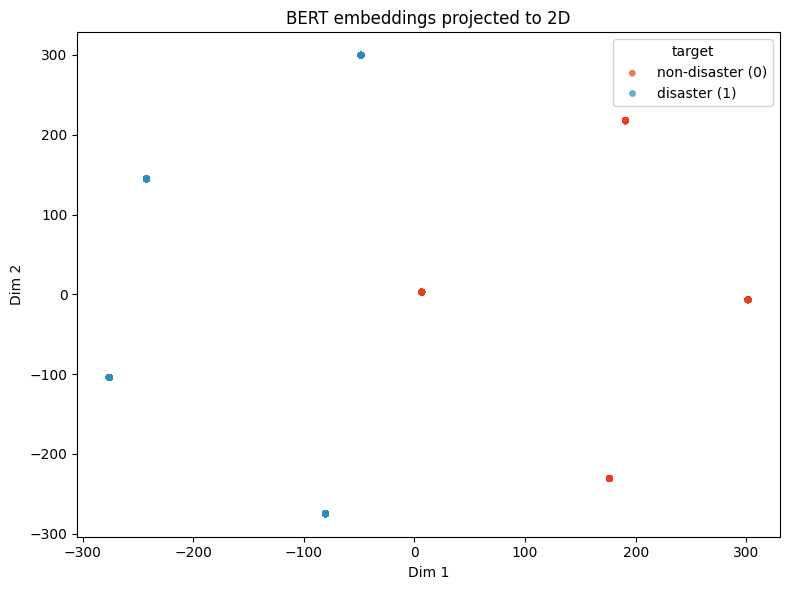

BERT silhouette score (2D projection): 0.3882


=== Interpretation & Discussion ===

Quick summary of silhouette scores (higher is better separation):
 - Word2Vec (mean word vectors): 0.4149775803089142
 - ELMo (contextual, char-based): 0.2780857980251312
 - BERT (contextual transformer): 0.3882065713405609

Observations (typical expected behaviour):
1) Word2Vec (non-contextual) uses static word vectors trained on co-occurrence; tweets are represented
   by averaging word vectors. This often blurs word order and ignores context, so tweets with similar
   word distributions but different meanings can overlap. Clusters can be noisy and less separable.

2) ELMo (contextual, deep bi-LSTM) provides context-sensitive word representations — tokens take on
   different vectors depending on surrounding words. Averaging ELMo token vectors usually yields
   better separation than Word2Vec for polysemous words, but still may not capture fine-grained sentence
   meaning as well as transformer model

In [1]:
import os
import sys
import random
import subprocess
import math
from pathlib import Path
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
random.seed(42)

# ----------------------------
# Auto-install helper
# ----------------------------
def pip_install(packages):
    import importlib
    for pkg in packages:
        try:
            importlib.import_module(pkg)
        except Exception:
            print(f"Installing {pkg} ...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

# Try to ensure required packages are present (best-effort).
pip_install(["pandas", "numpy", "matplotlib", "seaborn", "scikit-learn", "gensim", "transformers", "torch", "tensorflow", "tensorflow_hub"])

# Now imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# gensim Word2Vec
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

# transformers (BERT)
from transformers import AutoTokenizer, AutoModel
import torch

# TensorFlow + ELMo
import tensorflow as tf
import tensorflow_hub as hub

# ----------------------------
# Config
# ----------------------------
DATA_PATH = "/content/train.csv"   # expected columns: 'text', 'target'
SAMPLE_SIZE = 2000                  # limit for speed (set lower if CPU)
PLOT_DIR = "embedding_plots"
TSNE_PERPLEXITY = 30
TSNE_N_ITER = 1000
USE_TSNE = True                     # set False to use PCA instead
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BERT_MODEL_NAME = "bert-base-uncased"
ELMO_URL = "https://tfhub.dev/google/elmo/3"  # TF-hub ELMo
RANDOM_STATE = 42

os.makedirs(PLOT_DIR, exist_ok=True)
print("Device:", DEVICE)

# ----------------------------
# Load dataset or create synthetic demo
# ----------------------------
def load_or_create_dataset(path=DATA_PATH):
    if os.path.exists(path):
        df = pd.read_csv(path)
        if 'text' not in df.columns or 'target' not in df.columns:
            raise ValueError("CSV must contain columns 'text' and 'target'.")
        df = df[['text', 'target']].dropna().reset_index(drop=True)
        print(f"Loaded dataset: {len(df)} rows from {path}")
    else:
        print(f"File {path} not found — creating a small synthetic demo dataset.")
        # tiny synthetic example (not real disaster tweets)
        positive = [
            "Forest fire in spot near the highway, evacuation underway.",
            "Earthquake causes damage and people are trapped under rubble.",
            "Floods destroy many houses and emergency services respond.",
            "Wildfire spread quickly, homes destroyed, urgent help needed."
        ]
        negative = [
            "I love this product, works perfectly.",
            "What a beautiful day! Enjoying coffee in the morning.",
            "Looking forward to the concert this weekend.",
            "Just bought a new phone, battery lasts long."
        ]
        rows = []
        for i in range(400):
            rows.append({"text": random.choice(positive), "target": 1})
            rows.append({"text": random.choice(negative), "target": 0})
        df = pd.DataFrame(rows).sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
        print(f"Synthetic dataset created: {len(df)} rows.")
    return df

df = load_or_create_dataset(DATA_PATH)
if len(df) > SAMPLE_SIZE:
    df = df.sample(SAMPLE_SIZE, random_state=RANDOM_STATE).reset_index(drop=True)
print("Using sample size:", len(df))

# Basic preprocessing
def clean_text(s):
    if not isinstance(s, str):
        s = str(s)
    s = s.strip()
    return s

df['text'] = df['text'].astype(str).apply(clean_text)
texts = df['text'].tolist()
labels = df['target'].astype(int).tolist()

# ----------------------------
# Utility: visualize 2D embeddings colored by target
# ----------------------------
def plot_2d(xs, ys, labels, title, outpath):
    plt.figure(figsize=(8,6))
    palette = {0: "#2b8cbe", 1: "#f03b20"}  # non-disaster blue, disaster red
    sns.scatterplot(x=xs, y=ys, hue=labels, palette=palette, alpha=0.7, s=20, edgecolor=None)
    plt.title(title)
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.legend(title="target", labels=["non-disaster (0)", "disaster (1)"])
    plt.tight_layout()
    plt.savefig(outpath, dpi=200)
    plt.show()

# ----------------------------
# 1) Word2Vec embeddings
#    Train a Word2Vec model on the corpus; represent each tweet as mean of word vectors.
# ----------------------------
print("\n=== Computing Word2Vec embeddings ===")
tokenized = [simple_preprocess(t) for t in texts]  # gensim preprocessing (lowercasing, tokenizing)
w2v_model = Word2Vec(sentences=tokenized, vector_size=100, window=5, min_count=1, workers=2, seed=RANDOM_STATE)
w2v_vocab = set(w2v_model.wv.index_to_key)

def tweet_vector_w2v(tokens):
    vecs = []
    for w in tokens:
        if w in w2v_vocab:
            vecs.append(w2v_model.wv[w])
    if len(vecs) == 0:
        return np.zeros(w2v_model.vector_size, dtype=float)
    return np.mean(vecs, axis=0)

w2v_vectors = np.vstack([tweet_vector_w2v(toks) for toks in tokenized])
print("Word2Vec matrix shape:", w2v_vectors.shape)

# ----------------------------
# 2) ELMo embeddings via TF-Hub
# ----------------------------
use_elmo = True
elmo_vectors = None
try:
    print("\n=== Computing ELMo embeddings (this may be slow on first run) ===")
    # load module (cached locally by TF hub)
    elmo = hub.load(ELMO_URL)
    # elmo.signatures['default'] expects list of strings; we will use elmo.signatures['default'] if present
    # The module returns embeddings for tokens and/or sentence
    # We'll compute token embeddings and average them for a sentence vector.
    def elmo_embed(sentences):
        # elmo takes dict with 'tokens' or 'text' depending on version; safe call using 'signatures' if available
        # Use simple approach: call elmo(sentences, signature="default", as_dict=True)["elmo"] if supported.
        # But hub.load returns a callable that accepts a list of sentences for many versions.
        try:
            embeddings = elmo.signatures['default'](tf.constant(sentences))  # some versions accept this
            # If this returns dict, try to extract 'elmo' or 'default'
            if isinstance(embeddings, dict):
                if 'elmo' in embeddings:
                    arr = embeddings['elmo'].numpy()
                    return arr.mean(axis=1)  # mean over tokens
                else:
                    # fallback: try 'default'
                    key = list(embeddings.keys())[0]
                    arr = embeddings[key].numpy()
                    return arr.mean(axis=1)
            else:
                # If returns tensor-like for whole sentences, try averaging tokens
                arr = embeddings.numpy()
                return arr.mean(axis=1)
        except Exception:
            # simpler call: pass list and get "elmo" in result (older TF hub)
            res = elmo(tf.constant(sentences))
            # res is a dict with 'elmo' and 'default' keys in some versions
            if isinstance(res, dict):
                if 'elmo' in res:
                    arr = res['elmo'].numpy()
                    return arr.mean(axis=1)
                elif 'default' in res:
                    arr = res['default'].numpy()
                    return arr.mean(axis=1)
            # otherwise if tensor
            try:
                arr = res.numpy()
                # if arr is (N, T, D) average over T
                if arr.ndim == 3:
                    return arr.mean(axis=1)
                elif arr.ndim == 2:
                    return arr
            except Exception as e:
                raise e

    # compute elmo vectors in batches to avoid heavy memory use
    batch_size = 64
    elmo_list = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        emb = elmo_embed(batch)  # returns (batch, D) where D is 1024
        elmo_list.append(emb)
    elmo_vectors = np.vstack(elmo_list)
    print("ELMo matrix shape:", elmo_vectors.shape)
except Exception as e:
    print("ELMo extraction failed or tensorflow_hub ELMo not available in this environment.")
    print("Error:", e)
    use_elmo = False

# ----------------------------
# 3) BERT embeddings via transformers (mean pool of last hidden states)
# ----------------------------
print("\n=== Computing BERT embeddings ===")
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL_NAME)
bert_model = AutoModel.from_pretrained(BERT_MODEL_NAME)
bert_model.to(DEVICE)
bert_model.eval()

def bert_encode_texts(text_list, batch_size=32, pool='mean'):
    all_vecs = []
    with torch.no_grad():
        for i in range(0, len(text_list), batch_size):
            batch = text_list[i:i+batch_size]
            enc = tokenizer(batch, return_tensors='pt', truncation=True, padding=True, max_length=128)
            enc = {k: v.to(DEVICE) for k,v in enc.items()}
            out = bert_model(**enc, output_hidden_states=False, return_dict=True)
            last_hidden = out.last_hidden_state  # (batch, seq_len, hidden)
            if pool == 'cls':
                vecs = last_hidden[:,0,:].cpu().numpy()
            else:  # mean
                # mask padding tokens
                attention_mask = enc['attention_mask'].unsqueeze(-1)
                masked = last_hidden * attention_mask
                summed = masked.sum(dim=1).cpu().numpy()
                lens = attention_mask.sum(dim=1).cpu().numpy()
                vecs = summed / np.clip(lens, a_min=1e-9, a_max=None)
            all_vecs.append(vecs)
    return np.vstack(all_vecs)

bert_vectors = bert_encode_texts(texts, batch_size=32, pool='mean')
print("BERT matrix shape:", bert_vectors.shape)

# ----------------------------
# Standardize embeddings before dimensionality reduction (helps PCA/TSNE)
# ----------------------------
def reduce_and_plot(emb_matrix, name, labels, use_tsne=USE_TSNE):
    print(f"\n-- Reducing & visualizing {name} embeddings (shape {emb_matrix.shape}) --")
    # standardize
    scaler = StandardScaler()
    emb_scaled = scaler.fit_transform(emb_matrix)
    if use_tsne and emb_scaled.shape[0] >= 50:
        print("Running t-SNE... (this may take a while)")
        tsne = TSNE(n_components=2, perplexity=min(TSNE_PERPLEXITY, max(5, emb_scaled.shape[0]//5)),
                    n_iter=TSNE_N_ITER, random_state=RANDOM_STATE, init='pca')
        reduced = tsne.fit_transform(emb_scaled)
    else:
        print("Using PCA for dimensionality reduction")
        pca = PCA(n_components=2, random_state=RANDOM_STATE)
        reduced = pca.fit_transform(emb_scaled)
    xs, ys = reduced[:,0], reduced[:,1]
    outpath = os.path.join(PLOT_DIR, f"{name}_2d.png")
    plot_2d(xs, ys, labels, f"{name} embeddings projected to 2D", outpath)
    # silhouette (only sensible for >1 cluster)
    try:
        sil = silhouette_score(reduced, labels)
        print(f"{name} silhouette score (2D projection): {sil:.4f}")
    except Exception:
        sil = None
    return reduced, sil

w2v_red, w2v_sil = reduce_and_plot(w2v_vectors, "Word2Vec", labels)
if use_elmo and elmo_vectors is not None:
    elmo_red, elmo_sil = reduce_and_plot(elmo_vectors, "ELMo", labels)
else:
    elmo_red, elmo_sil = None, None
bert_red, bert_sil = reduce_and_plot(bert_vectors, "BERT", labels)

# ----------------------------
# Interpretation & Discussion (printed)
# ----------------------------
print("\n\n=== Interpretation & Discussion ===\n")
print("Quick summary of silhouette scores (higher is better separation):")
print(f" - Word2Vec (mean word vectors): {w2v_sil}")
if use_elmo:
    print(f" - ELMo (contextual, char-based): {elmo_sil}")
else:
    print(" - ELMo: not available / skipped")
print(f" - BERT (contextual transformer): {bert_sil}\n")

print("Observations (typical expected behaviour):")
print("1) Word2Vec (non-contextual) uses static word vectors trained on co-occurrence; tweets are represented")
print("   by averaging word vectors. This often blurs word order and ignores context, so tweets with similar")
print("   word distributions but different meanings can overlap. Clusters can be noisy and less separable.\n")
print("2) ELMo (contextual, deep bi-LSTM) provides context-sensitive word representations — tokens take on")
print("   different vectors depending on surrounding words. Averaging ELMo token vectors usually yields")
print("   better separation than Word2Vec for polysemous words, but still may not capture fine-grained sentence")
print("   meaning as well as transformer models for some tasks.\n")
print("3) BERT (transformer) uses deep bidirectional attention and is pretrained with masked language modeling.")
print("   BERT's sentence-level vectors (mean-pooled or CLS) capture richer contextual patterns and syntax,")
print("   allowing the model to distinguish tweets that share words but differ in semantics, tone, or negation.")
print("   In practice, BERT projections often show clearer clusters separating disaster vs non-disaster tweets.\n")

print("Why BERT usually shows better separation (summary):")
print("- Contextualized tokens: BERT produces token vectors that reflect the full sentence context; negation")
print("  and subtle cues are preserved, helping discriminate sentiment/intent.")
print("- Self-attention: BERT can give higher importance to critical tokens (e.g., 'fire', 'flood', 'trapped'),")
print("  which strongly influence sentence embeddings even if those tokens are infrequent.")
print("- Pretraining objectives: BERT's masked-language objective encourages learning representations that")
print("  capture relationships across tokens useful for downstream classification.")
print("- Deep, multi-head representations: the model encodes multiple aspects (syntax, semantics, topicality),")
print("  which PCA/t-SNE can reveal as better-separated clusters.\n")

print("Practical notes:")
print("- If you need better cluster quality, compute embeddings using the fine-tuned BERT model on your task")
print("  (fine-tuning aligns representation space with the target classes).")
print("- For ELMo, prefer using the sentence-level representation returned by the module if available rather")
print("  than averaging tokens, or experiment with weighted pooling (attention over tokens).")
print("- t-SNE often gives visually pleasing separation but is non-deterministic and may distort global structure.")
print("  Use PCA for quick diagnostics, and try multiple random seeds for robustness.\n")

print("Files saved in", PLOT_DIR)
print("Done.")